## Librerias y primer vistazo a los datos

In [47]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
data = pd.read_csv('dataset\df_200k.csv')
data.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   id      200000 non-null  int64 
 2   date    200000 non-null  object
 3   query   200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


In [50]:
data.describe()

,target,id
count,200000.0,2.000000e+05
mean,0.0,1.772565e+09
std,0.0,1.520760e+08
min,0.0,1.467810e+09
25%,0.0,1.678338e+09
50%,0.0,1.793821e+09
75%,0.0,1.883596e+09
max,0.0,1.971571e+09


In [51]:
data.isnull().sum()

target    0
id        0
date      0
query     0
user      0
text      0
dtype: int64

In [52]:
data_clean = data[["text"]]
data_clean.head()

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."


## 1. Análisis exploratorio y preprocesamiento

### Análisis estadístico del corpus 

In [53]:
# Tokenización y limpieza básica (quita URLs, menciones, puntuación básica)
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', ' ', text)        # URLs
    text = re.sub(r'@\w+', ' ', text)           # menciones
    text = re.sub(r'#', ' ', text)              # quitar # pero mantener la palabra

    # conservar letras y números (incluye acentos)
    # quitar acentos 
    text = re.sub(r'[^0-9a-záéíóúüñ\s]', ' ', text, flags=re.IGNORECASE)
    tokens = re.findall(r'\w+', text, flags=re.UNICODE)
    return tokens

In [54]:
# Construir distribución de frecuencias de tokens
freq = Counter()
total_tokens = 0
for doc in data_clean['text'].astype(str):
    toks = clean_and_tokenize(doc)
    freq.update(toks)
    total_tokens += len(toks)

vocab = len(freq)
print(f"Tokens totales: {total_tokens:,}")
print(f"Vocabulario (tipos): {vocab:,}")


Tokens totales: 2,736,879
Vocabulario (tipos): 75,418


In [55]:
# DataFrame-like structures para análisis
words, counts = zip(*freq.most_common())
ranks = np.arange(1, len(counts) + 1)
counts_arr = np.array(counts)


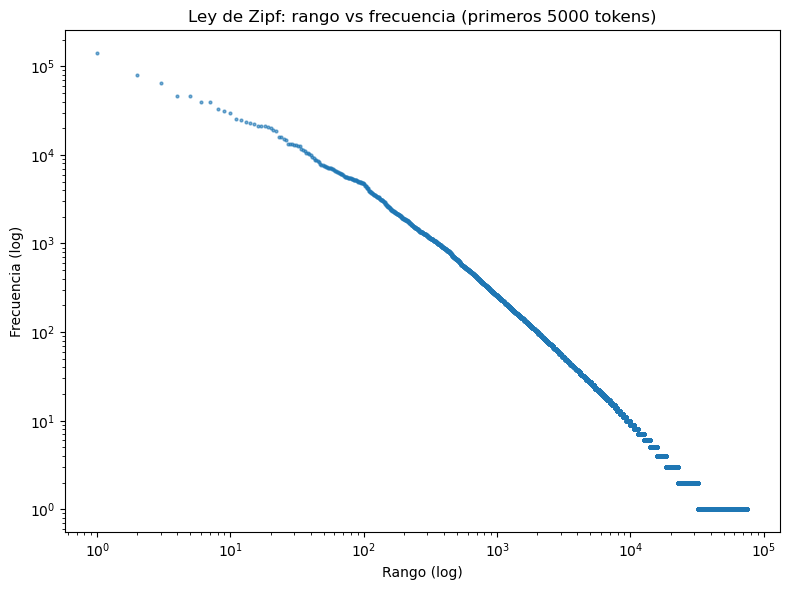

In [ ]:
# Ley de Zipf: gráfico rango vs frecuencia (log-log) y ajuste lineal en log-log
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Ley de Zipf: rango vs frecuencia ')
plt.tight_layout()
plt.show()


Ajuste log-log (primeros 2000): slope = -1.1871, intercept = 13.7391
Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)


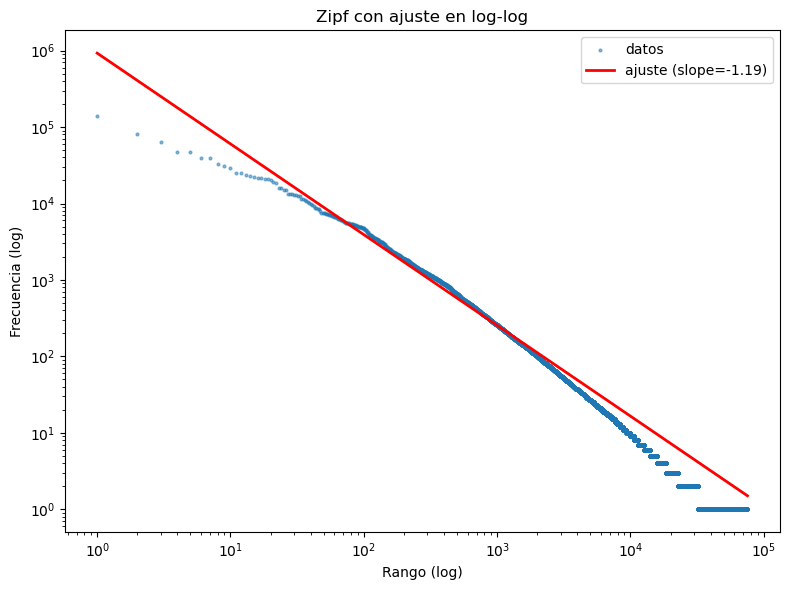

In [62]:
# Ajuste lineal en log-log para los primeros K ranks (p. ej. 1..2000)
K = min(2000, len(counts_arr))
log_r = np.log(ranks[:K])
log_f = np.log(counts_arr[:K])
slope, intercept = np.polyfit(log_r, log_f, 1)
print(f"Ajuste log-log (primeros {K}): slope = {slope:.4f}, intercept = {intercept:.4f}")
print("Interpretación: frecuencia ~ C * rank^{slope} (esperado ~ -1 para Zipf clásico)")

# Dibujar la línea ajustada sobre el scatter 
pred_logf = intercept + slope * np.log(ranks[:])
pred_f = np.exp(pred_logf)
plt.figure(figsize=(8,6))
plt.scatter(ranks[:], counts_arr[:], s=4, alpha=0.5, label='datos')
plt.plot(ranks[:], pred_f, color='red', lw=2, label=f'ajuste (slope={slope:.2f})')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Rango (log)')
plt.ylabel('Frecuencia (log)')
plt.title('Zipf con ajuste en log-log')
plt.legend()
plt.tight_layout()
plt.show()

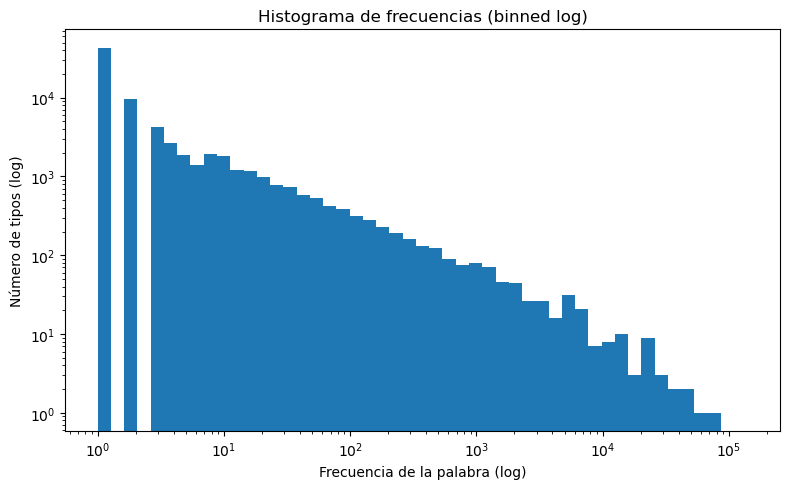

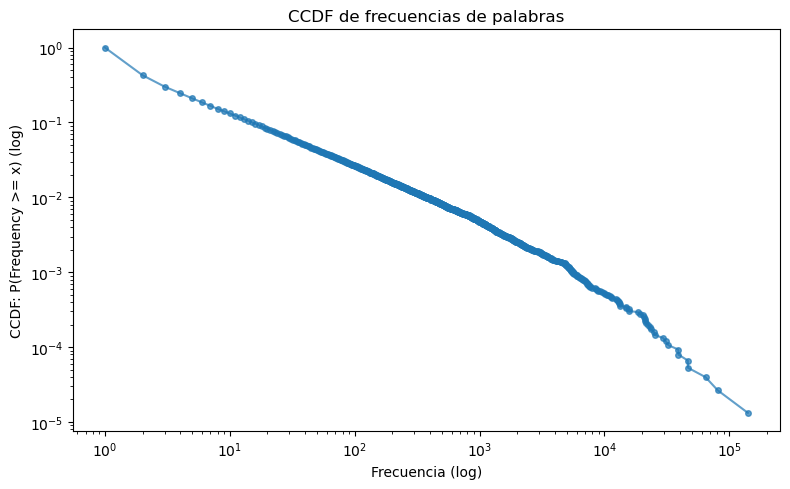

In [58]:
# Distribución de frecuencias: histograma (log-binned) y CCDF
# Histograma con ejes log
plt.figure(figsize=(8,5))
plt.hist(counts_arr, bins=np.logspace(np.log10(1), np.log10(counts_arr.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frecuencia de la palabra (log)')
plt.ylabel('Número de tipos (log)')
plt.title('Histograma de frecuencias (binned log)')
plt.tight_layout()
plt.show()

# CCDF: proporción de tipos con frecuencia >= x
sorted_counts = np.sort(counts_arr)
unique_vals, counts_of_vals = np.unique(sorted_counts, return_counts=True)
ccdf_vals = np.cumsum(counts_of_vals[::-1])[::-1] / vocab  # proporción de tipos >= val
plt.figure(figsize=(8,5))
plt.loglog(unique_vals, ccdf_vals, marker='o', ms=4, alpha=0.7)
plt.xlabel('Frecuencia (log)')
plt.ylabel('CCDF: P(Frequency >= x) (log)')
plt.title('CCDF de frecuencias de palabras')
plt.tight_layout()
plt.show()

Heaps fit: V = 12.30 * N^0.5883  (beta típico entre 0.4-0.6)


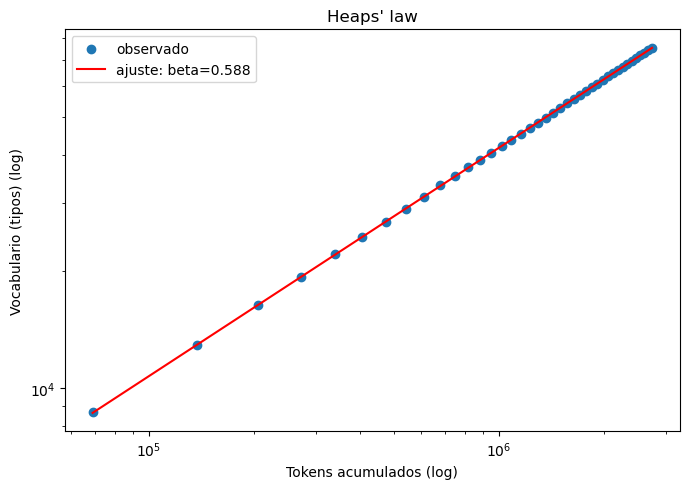

In [59]:
# Heaps' law: crecimiento del vocabulario con tokens acumulados
# Recorremos documentos en orden y acumulamos vocab cada N documentos
step_docs = 5000
vocab_growth_tokens = []
vocab_growth_types = []
acc_tokens = 0
seen = set()
for i, doc in enumerate(data_clean['text'].astype(str), 1):
    toks = clean_and_tokenize(doc)
    acc_tokens += len(toks)
    seen.update(toks)
    if i % step_docs == 0 or i == len(data_clean):
        vocab_growth_tokens.append(acc_tokens)
        vocab_growth_types.append(len(seen))

vg_t = np.array(vocab_growth_tokens)
vg_v = np.array(vocab_growth_types)
# Ajuste power-law: V = K * N^beta  => log V = log K + beta * log N
mask = vg_t > 0
beta, logK = np.polyfit(np.log(vg_t[mask]), np.log(vg_v[mask]), 1)
K = np.exp(logK)
print(f"Heaps fit: V = {K:.2f} * N^{beta:.4f}  (beta típico entre 0.4-0.6)")

plt.figure(figsize=(7,5))
plt.scatter(vg_t, vg_v, label='observado')
plt.plot(vg_t, K * (vg_t ** beta), color='r', label=f'ajuste: beta={beta:.3f}')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Tokens acumulados (log)')
plt.ylabel('Vocabulario (tipos) (log)')
plt.title("Heaps' law")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
# Resumen: top-20 palabras
top_n = 20
print(f"\nTop {top_n} palabras:")
for i, (w, c) in enumerate(freq.most_common(top_n), 1):
    print(f"{i:2d}. {w:15s} {c:,} ({c/total_tokens:.4%} del total de tokens)")


Top 20 palabras:
 1. i               140,663 (5.1395% del total de tokens)
 2. to              80,731 (2.9497% del total de tokens)
 3. the             64,433 (2.3543% del total de tokens)
 4. a               46,639 (1.7041% del total de tokens)
 5. my              46,498 (1.6989% del total de tokens)
 6. it              39,108 (1.4289% del total de tokens)
 7. and             39,011 (1.4254% del total de tokens)
 8. is              32,534 (1.1887% del total de tokens)
 9. t               30,928 (1.1300% del total de tokens)
10. in              29,459 (1.0764% del total de tokens)
11. you             25,162 (0.9194% del total de tokens)
12. for             24,921 (0.9106% del total de tokens)
13. of              23,610 (0.8627% del total de tokens)
14. s               23,077 (0.8432% del total de tokens)
15. me              22,412 (0.8189% del total de tokens)
16. on              21,345 (0.7799% del total de tokens)
17. so              21,295 (0.7781% del total de tokens)
18. but     